# Recursive Least Squares

This notebook implements the Recurisve Least squares algorithm used for online sys-id.


2020.11.01: E.R.


## Least squares system identification


Given input data $[u_0, u_1, ..., u_{N-1}]$  and output data $ [y_0, y_1, ..., y_N]$.

The goal is to estimate a discrete transfer function $G(z) = \frac{B(z)}{A(z)}$ for the data sequences.

$$
G(z) = \frac{b_{1}\, z^{n-1} + ...  + b_{n-1} \, z + b_{n} }{z^n + a_{1}\, z^{n-1} + ...  + a_{n-1} \, z + a_n}
$$

The difference equation for the system is then explicity

$$
y[k] = -a_1 \, y[k-1] - a_2 \, y[k-2] - ... - a_n \, y[k-n] + b_1 \, u[k-1] + b_2 \, u[k-2] + ... + b_{n} \, u[k-n]
$$

Where the parameter vector $\theta$ is defined as

$$
\theta = [a_{1}, ..., a_n, b_{1}, ..., b_n]^T \ .
$$

Defining the regressor $\varphi_{k-1}$ as

$$
\varphi_{k-1} = [-y[k-1], ... ,-y[k-n], u[k-1], ..., u[k-n]]^T
$$

then the output can be described as

$$
y_k = \varphi^T_{k-1} \, \theta
$$



## Least squares for entire sequence

$$
\Phi = \left[
\begin{array}{c}
\varphi_{j}^T \\
\varphi_{j+1}^T \\
\varphi_{j+2}^T \\
\vdots \\
\varphi_{j+n-1}^T 
\end{array}
\right]
$$


$$
Y = [y[j+1], \quad y[j+2], \quad y[j+3], \, ... \, y[j+n]]
$$

Then

$$
\Phi \, \theta = Y
$$


$$
\hat{\theta} = \left(\Phi^T \, \Phi \right)^{-1} \Phi^T \, Y
$$


Weighting the error with a weight matrix $W$

$$
\hat{\theta} = \left(\Phi^T \, W\, \Phi \right)^{-1}  \Phi^T \, W\, Y
$$



In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import control
from scipy.linalg import inv

## Generate test sequence

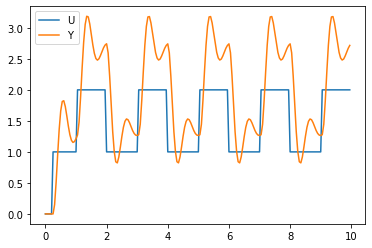


  0.1485 z + 0.1343
----------------------
z^2 - 1.529 z + 0.7408

dt = 0.05

In [2]:
Tf = 10
dT = 0.05

# True plant
w0 = 10
zeta = 0.3
Kp = 1.337

G = control.tf([w0**2],[1,2*w0*zeta,w0**2])*Kp


N = int(Tf/dT)

# Discretize

Gd = control.sample_system(G,dT)

GD_A = Gd.den[0][0]
GD_B = Gd.num[0][0]

b0 = GD_B[0]
b1 = GD_B[1]

a1 = GD_A[1]
a2 = GD_A[2]

Y = np.zeros(N)
T = np.linspace(0,(N-1)*dT,N)

# Ref signal
sq_p = int(2/dT)
U = [1 + round((i % sq_p)/sq_p) for i in range(N)]
U = np.array(U)

U[0:5] = 0

theta_true = np.array([a1,a2,b0,b1])

for i in range(2,N):
    phi = np.array([-Y[i-1],-Y[i-2],U[i-1],U[i-2]])
    Y[i] = phi @ theta_true


plt.plot(T,U)
plt.plot(T,Y)
plt.legend(['U','Y'])
plt.show()

Gd

## Normal least squares for entire sequence

In [3]:
# Normal least squares solution


M = np.zeros((N,4))
B = np.zeros(N)

for i,k in enumerate(range(2,N-1)):
    M[i,:] = np.array([-Y[k-1], -Y[k-2],U[k-1],U[k-2]])
    B[i] = Y[k]
    
theta_hat = inv(M.T @ M) @ M.T @ B

# Estimate with discount factor
Nm = len(M)
lamb = 0.7
w_lambda = 0.9**np.linspace(0,Nm-1,Nm) 
w_lambda = np.flip(w_lambda)

W = np.diag(w_lambda)

theta_hat_w = inv(M.T @ W @ M) @ M.T@ W @ B



print("True theta")
print(theta_true)

print("Estimated theta")
print(theta_hat)

print("Estimated theta w/ discount")
print(theta_hat_w)



True theta
[-1.5292891   0.74081822  0.14852619  0.13428824]
Estimated theta
[-1.5292891   0.74081822  0.14852619  0.13428824]
Estimated theta w/ discount
[-1.5292891   0.74081822  0.14852619  0.13428824]


In [4]:
# Functions for use in comparison to the recursive algorithm

def ls(U,Y):
    N = len(Y)-2
    
    M = np.zeros((N,4))
    B = np.zeros(N)

    for i,k in enumerate(range(2,N-1)):
        M[i,:] = np.array([-Y[k-1], -Y[k-2],U[k-1],U[k-2]])
        B[i] = Y[k]

    theta_hat = inv(M.T @ M) @ M.T @ B
    return theta_hat


def ls_lambda(U, Y, lamb):
    N = len(Y)-2

    M = np.zeros((N,4))
    B = np.zeros(N)

    for i,k in enumerate(range(2,N-1)):
        M[i,:] = np.array([-Y[k-1], -Y[k-2],U[k-1],U[k-2]])
        B[i] = Y[k]

    w_lambda = lamb**np.linspace(0,N-1,N) 
    w_lambda = np.flip(w_lambda)
    W = np.diag(w_lambda)
    
    if abs(np.linalg.det(M.T @ W @ M)) < 1e-6:
        return np.zeros(4)
    else:
        theta_hat_w = inv(M.T @ W @ M) @ M.T@ W @ B
        return theta_hat_w
    


print(ls(U,Y))
print(ls_lambda(U,Y,0.9))

[-1.5292891   0.74081822  0.14852619  0.13428824]
[-1.5292891   0.74081822  0.14852619  0.13428824]


## Recursive Least Squares algorithm
From "Adaptive control" By K.J. Åström & Björn Wittermark, the RLS algorithm is then defined as:

$$
\theta_k = \theta_{k-1} + K \, (y_k - \varphi_{k-1}^T \, \theta_{k-1})
$$

$$
K = P_{k-1} \, \varphi_{k-1} \, (\lambda + \varphi_{k-1}^T \, P_{k-1} \, \varphi_{k-1})^{-1}
$$

$$
P_k = (I - K\, \varphi_{k-1}^T) \, P_{k-1} \, \frac{1}{\lambda}
$$

For a sample intervall of $\delta_T$ and a desired forgetting time constant $T_f$ the choice of lambda is recomended as

$$
\lambda = e^{-\delta_T/T_f}
$$

## Estimate parameters from test data


0.9950124791926823


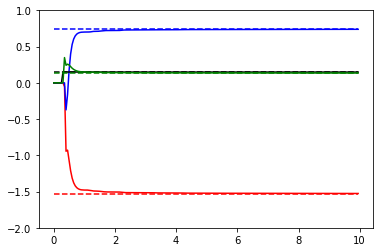

In [7]:

THETAs = np.zeros((4,N))
Ps = np.zeros((4,4,N))

lamb = np.exp(-dT/10)

print(lamb)
theta = np.zeros(4)

P = np.eye(4)*100 # Tuning parameter, what to initalize the parameter variance to

for i in range(2,N):
    
    # Fetch all variables
    phi = np.array([-Y[i-1],-Y[i-2],U[i-1],U[i-2]])
    K = P @ phi * 1/(lamb + phi.T @ P @ phi)
    P = (np.eye(4) - np.outer(K, phi))@P*1/lamb # The np.outer function was missing and caused me a lot of trouble...

    theta = theta + K*(Y[i] - phi.T @ theta)
    
    Ps[:,:,i] = P
    THETAs[:,i] = theta
    
plt.plot(T,THETAs[0,:],'r')
plt.plot(T,np.ones(N)*a1,'r--')

plt.plot(T,THETAs[1,:],'b')
plt.plot(T,np.ones(N)*a2,'b--')

plt.plot(T,THETAs[2,:],'k')
plt.plot(T,np.ones(N)*b0,'k--')

plt.plot(T,THETAs[3,:],'g')
plt.plot(T,np.ones(N)*b1,'g--')

plt.ylim([-2,1])
plt.savefig('rls_params.png',dpi=300)
plt.show()




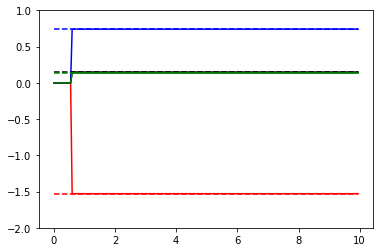

In [8]:
# Comparison running the non-recursive least squares with discount
# Note that the conventional least squares does not produce any output until after
# approx 5-10 samples.

from scipy.linalg import inv

THETAs = np.zeros((4,N))

#lamb = 0.9

Y_MEAS = np.array([0])
U_MEAS = np.array([0])

for i in range(2,N):
    
    # Fetch all variables
    Y_MEAS = np.append(Y_MEAS,Y[i])
    U_MEAS = np.append(U_MEAS,U[i])
    
    #THETAs[:,i] = ls(U_MEAS,Y_MEAS)
    THETAs[:,i] = ls_lambda(U_MEAS,Y_MEAS,lamb)
    

plt.plot(T,THETAs[0,:],'r')
plt.plot(T,np.ones(N)*a1,'r--')

plt.plot(T,THETAs[1,:],'b')
plt.plot(T,np.ones(N)*a2,'b--')

plt.plot(T,THETAs[2,:],'k')
plt.plot(T,np.ones(N)*b0,'k--')

plt.plot(T,THETAs[3,:],'g')
plt.plot(T,np.ones(N)*b1,'g--')

plt.ylim([-2,1])

plt.show()


## Parameter uncertainty
Appart from the parameter estimates them self, the $P$ matrix is the convariance matrix of the estimated parameters. So one can also include the parameter uncertainty in the estimate. This estimate is related to the choice of $\lambda$.

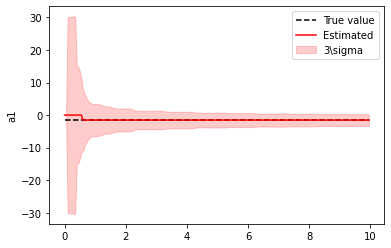

In [9]:

a1_hat = THETAs[0,:]
a1_var = Ps[0,0,:]
a1_sigma = np.sqrt(a1_var)

a1_upper = a1_hat + 3*a1_sigma
a1_lower = a1_hat - 3*a1_sigma

plt.plot(T,np.ones(N)*a1,'k--')
plt.plot(T,a1_hat,'r')
plt.fill_between(T,a1_upper,a1_lower,color='r',alpha=0.2)

plt.ylabel('a1')
plt.legend(['True value','Estimated','3\sigma'])
plt.savefig('rls_estim_var.png',dpi=300)
plt.show()


## RLS Class for future use
Please note that it is not intended for production use!

In [10]:
class RLS:
    def __init__(self, nr_u, nr_y, d0, lamb, theta0 = None, P0 = None):
        
        self.nr_u = nr_u
        self.nr_y = nr_y
        self.lamb = lamb
        self.d0 = d0
        
        self.old_u = np.zeros(nr_u + d0)
        self.old_y = np.zeros(nr_y)
        
        th_dim = nr_u + nr_y
        
        if type(theta0) != type(None):
            self.theta = theta0
        else:
            self.theta = np.zeros(th_dim)
            
        if type(P0) != type(None):
            self.P = P0
        else:
            self.P = np.eye(th_dim)
                

    def sample(self, u, y):
        
        self.old_u[1:] = self.old_u[0:-1]
        self.old_u[0] = u
        
        phi = np.concatenate([-self.old_y, self.old_u[self.d0:]])
        lamb = self.lamb
        
        P = self.P
        theta = self.theta
        
        PN = self.nr_u + self.nr_y
        
        K = P @ phi * 1/(lamb + phi.T @ P @ phi)
        P = (np.eye(PN) - np.outer(K, phi))@P*1/lamb 

        theta = theta + K*(y - phi.T @ theta)
        
        self.theta = theta
        self.P = P
        
        self.old_y[1:] = self.old_y[0:-1]
        self.old_y[0] = y
        
        return theta
    
    def get_estimate(self):
        return self.theta
    
    def get_variance(self):
        return self.P


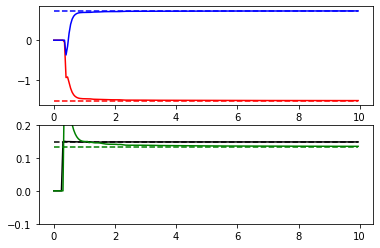

In [11]:
THETAs = np.zeros((4,N))
Ps = np.zeros((4,4,N))

lamb = np.exp(-dT/10)

P0 = np.eye(4)*100 # Tuning parameter, what to initalize the parameter variance to

rls = RLS(2,2,1,lamb,P0 = P0)


for i in range(N):
    
    rls.sample(U[i],Y[i])
    
    
    Ps[:,:,i] = rls.get_variance()
    THETAs[:,i] = rls.get_estimate()
    
plt.subplot(2,1,1)
plt.plot(T,THETAs[0,:],'r')
plt.plot(T,np.ones(N)*a1,'r--')

plt.plot(T,THETAs[1,:],'b')
plt.plot(T,np.ones(N)*a2,'b--')


plt.subplot(2,1,2)

plt.plot(T,THETAs[2,:],'k')
plt.plot(T,np.ones(N)*b0,'k--')

plt.plot(T,THETAs[3,:],'g')
plt.plot(T,np.ones(N)*b1,'g--')


plt.ylim([-0.1,0.2])

plt.show()